<a href="https://colab.research.google.com/github/monimoyd/Assignment14/blob/master/shake_drop_tf_combined_assignment14_3_best_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: 14

## Submitters:

Monimoy Deb Purkayatha (monimoyd@gmail.com)
Kartheek Kanagala (kanagala.k@gmail.com)
Krisna Gorrepati (krishnagorrepati@gmail.com)
Chaitali Deb Purkayastha (chaitalidebp@gmail.com)
Vikas Kumar Sharma(vikas.reply@gmail.com)

## Objective:


In this assignment:

i. We have to run training on CIFAR-10 dataset and achieve accuracy of 94%
ii. Training should be done in 100 seconds
iii. Need to train on V100 machine


## Implementaion

- We have used shake Davidnet architecute, modified parameters
- Added Shake and Drop regularization
- Added the pregenerated cutout images







## Import all the Keras libraries 

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 

from tensorflow.python.keras import utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers


from tensorflow.keras import Model
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, Layer,InputSpec, GlobalMaxPool2D,  Activation, Flatten, Dense, Dropout, Input, Concatenate, GlobalAveragePooling2D, SeparableConv2D, Lambda, Add, SpatialDropout2D
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.initializers import Initializer
from tensorflow.python.keras.backend import _regular_normalize_batch_in_training





In [0]:

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

## Mount the google drive to save the model

In [0]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load the  train features, train labels, test features, train labels from CIFAR10 dataset 

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step


## Define class names and display
* Define the 10 classes as airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
* Display one element from each class

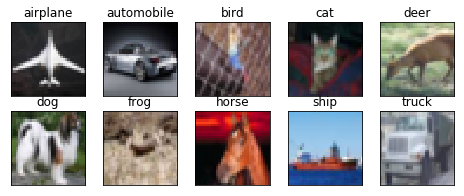

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Define a method for diplaying model history
Define a method plot_model_history for displaying model history which will do the following
* Plot Model accuracy (both the training and validation accuracy) vs number of epochs. 
* Model loss ((both the training and validation accuracy) vs number of epoch


In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Define a method for calculate accuracy

Define a mehod accuracy which will calculate accuracy from model
* Get True class
* Get Predicted class
* Get numbe of correc predictions
* Divide number of correct predictions by total number of elements to get the accuracy


In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Perform pixel normalization of features and one hot encoding of train and test

* Perform pixel normalization by dividing train and test features by 255
* Use to_categorical method of np_utils to use one hot encoding to Convert the train_labels, test_labels to 10 dimensional categorical matrix

In [0]:
#train_features = train_features.astype('float32')/255
#test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
#train_labels = np_utils.to_categorical(train_labels, num_classes)
#test_labels = np_utils.to_categorical(test_labels, num_classes)


#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
import random
x_train, y_train, x_test, y_test = train_features, train_labels, test_features, test_labels

index_list_aug1 = random.sample(range(len(x_train)), 25000)
print("index_list_aug1 len=", len(index_list_aug1))
x_train_aug1,y_train_aug1 = np.copy(x_train[index_list_aug1]), np.copy(y_train[index_list_aug1])
print("x_train_aug1.shape=", x_train_aug1.shape)
print("y_train_aug1.shape=", y_train_aug1.shape)

index_list_aug2 = random.sample(range(len(x_train)), 25000)
x_train_aug2,y_train_aug2 = np.copy(x_train[index_list_aug2]), np.copy(y_train[index_list_aug2])

x_test_aug1, y_test_aug1 = np.copy(x_test), np.copy(y_test)
x_test_aug2, y_test_aug2 = np.copy(x_test), np.copy(y_test)


len_train, len_test = len(x_train), len(x_test)
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
#pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

#x_train = normalize(pad4(x_train))
x_train = normalize(x_train)
x_test = normalize(x_test)

index_list_aug1 len= 25000
x_train_aug1.shape= (25000, 32, 32, 3)
y_train_aug1.shape= (25000, 1)


In [0]:
!cp '/content/drive/My Drive/img_aug_cutout_x.npy' .
!cp '/content/drive/My Drive/lables_cutout.npy' .

In [0]:
cutout_x = np.load('img_aug_cutout_x.npy',encoding='latin1')
cutout_y = np.load('lables_cutout.npy',encoding='latin1')
cutout_y = cutout_y.reshape(cutout_y.shape[0], 1)

In [0]:
print(len(index_list_aug1))

25000


In [0]:
index_list_aug1 = random.sample(range(len(cutout_x)), 25000)
x_aug1 = cutout_x[index_list_aug1]
y_aug1 = cutout_y[index_list_aug1]

print("x_train_aug1.shape= ", x_train_aug1.shape)
print("x_aug1.shape= ", x_aug1.shape)
print("y_aug1.shape= ", y_aug1.shape)

x_train_aug1=np.append(x_train_aug1, x_aug1, axis=0)
y_train_aug1=np.append(y_train_aug1, y_aug1, axis=0)

len_train_aug1, len_test_aug1 = len(x_train_aug1), len(x_test_aug1)
y_train_aug1 = utils.to_categorical(y_train_aug1, num_classes)
y_test_aug1 = utils.to_categorical(y_test_aug1, num_classes)

train_aug1_mean = np.mean(x_train_aug1, axis=(0,1,2))
train_aug1_std = np.std(x_train_aug1, axis=(0,1,2))

normalize = lambda x: ((x - train_aug1_mean) / train_aug1_std).astype('float32') # todo: check here
#pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

#x_train = normalize(pad4(x_train))
x_train_aug1 = normalize(x_train_aug1)
x_test_aug1 = normalize(x_test_aug1)

x_train_aug1.shape=  (25000, 32, 32, 3)
x_aug1.shape=  (25000, 32, 32, 3)
y_aug1.shape=  (25000, 1)


In [0]:
index_list_aug2 = random.sample(range(len(cutout_x)), 25000)
x_aug2 = cutout_x[index_list_aug2]
y_aug2 = cutout_y[index_list_aug2]

x_train_aug2 = np.append(x_train_aug2, x_aug2, axis=0)
y_train_aug2 = np.append(y_train_aug2, y_aug2, axis=0)

len_train_aug2, len_test_aug2 = len(x_train_aug2), len(x_test_aug2)
y_train_aug2 = utils.to_categorical(y_train_aug2, num_classes)
y_test_aug2 = utils.to_categorical(y_test_aug2, num_classes)

train_aug2_mean = np.mean(x_train_aug2, axis=(0,1,2))
train_aug2_std = np.std(x_train_aug2, axis=(0,1,2))

normalize = lambda x: ((x - train_aug2_mean) / train_aug2_std).astype('float32') # todo: check here
#pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

#x_train = normalize(pad4(x_train))
x_train_aug2 = normalize(x_train_aug2)
x_test_aug2 = normalize(x_test_aug2)

In [0]:
import scipy
import scipy.misc
import skimage.transform
new_shape_16 = (16,16,3)
new_shape_24 = (24,24,3)
x_train_16 = np.empty(shape=(x_train.shape[0],)+new_shape_16)
x_train_24 = np.empty(shape=(x_train.shape[0],)+new_shape_24)
for idx in range(x_train.shape[0]):
    x_train_16[idx] = skimage.transform.resize(x_train[idx], new_shape_16)
    x_train_24[idx] = skimage.transform.resize(x_train[idx], new_shape_24)


In [0]:
#TODO : Chnage for V100
NUM_PARALLEL_CALLS=2

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
 
 
def save_tf_records(x_train, y_train, path, file_prefix):
    
    chunk_size = 10000
    num_chunks = int(x_train.shape[0] / chunk_size )
    if int(x_train.shape[0] % chunk_size) > 0:
        num_chunks += 1
    current_pointer = 0
    write = None
    for chunk in range(num_chunks):
        writer = tf.python_io.TFRecordWriter(path + '/' + file_prefix + "_" + str(chunk+1) + ".tfrecord")
        
        x_chunk = x_train[current_pointer: current_pointer + chunk_size]
        y_chunk = y_train[current_pointer: current_pointer + chunk_size]
        current_pointer += chunk_size
        for i in range(chunk_size):
            example = tf.train.Example(features=tf.train.Features(
                feature={'image': _bytes_feature(x_train[i].tostring()),
                         'label': _bytes_feature(
                             y_train[i].tostring())
                         }))
 
        writer.write(example.SerializeToString())
        if writer is not None:
            writer.close()
  
def load_tf_records(filenames, dimension=()): 
   
 
    def parse_fn(record):
       
        featdef = {
            'image': tf.FixedLenFeature(shape=[], dtype=tf.string),
            'labels': tf.FixedLenFeature(shape=[], dtype=tf.string),
        }
 
        example = tf.parse_single_example(record, featdef)
        im = tf.decode_raw(example['image'], tf.float32)
        im = tf.reshape(im, dimension)
        lbl = tf.decode_raw(example['labels'], tf.int64)
        return im, lbl
       
      
    files = tf.data.Dataset.list_files(filenames)
    #dataset = files.interleave(tf.data.TFRecordDataset)
    dataset = files.apply(tf.contrib.data.parallel_interleave(tf.data.TFRecordDataset, cycle_length=2))
    dataset = dataset.shuffle(buffer_size=100000)
    #dataset = dataset.apply(tf.contrib.data.map_and_batch(
    #map_func=parse_fn, batch_size=FLAGS))
    dataset = dataset.map(map_func=parse_fn, num_parallel_calls=NUM_PARALLEL_CALLS)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=BATCH_SIZE)
    #iterator = dataset.make_one_shot_iterator()
    dataset = dataset.repeat(24)
    iterator = dataset.make_one_shot_iterator()
    features, labels = iterator.get_next()
 
    return features, labels
    #return iterator
    
    #dataset = tf.data.TFRecordDataset(filenames)
     
    #dataset = dataset.map(parser)
    #dataset = dataset.shuffle(buffer_size=50000)
    #dataset = dataset.batch(50000)
    #dataset = dataset.repeat(1)
    
    #return iterator.get_next()


In [0]:
save_tf_records(x_train, y_train, '.', 'train_32')

In [0]:
!ls -l

total 150488
drwx------ 3 root root      4096 Aug 25 05:05 drive
-rw------- 1 root root 153600128 Aug 25 05:05 img_aug_cutout_x.npy
-rw------- 1 root root    400128 Aug 25 05:05 lables_cutout.npy
drwxr-xr-x 1 root root      4096 Aug 22 16:14 sample_data
-rw-r--r-- 1 root root     12381 Aug 25 05:08 train_32_1.tfrecord
-rw-r--r-- 1 root root     12381 Aug 25 05:08 train_32_2.tfrecord
-rw-r--r-- 1 root root     12381 Aug 25 05:08 train_32_3.tfrecord
-rw-r--r-- 1 root root     12381 Aug 25 05:08 train_32_4.tfrecord
-rw-r--r-- 1 root root     12381 Aug 25 05:08 train_32_5.tfrecord


In [0]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

## Define Methods used for generating  model


In [0]:
class ShakeDrop(Layer):

    def __init__(self,**kwargs):
        
        super(ShakeDrop, self).__init__(**kwargs)

    def build(self, input_shape):
       
        super(ShakeDrop, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        print(x.shape)
        #assert isinstance(x, list)
        batch_size = K.shape(x)[0]
        print("batch",batch_size)
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        beta = K.random_uniform((batch_size, 1, 1, 1))
        
        #prob = tf.ones(shape=[batch_size, 1, 1, 1])*0.5
        bernoulli_dis = tf.distributions.Bernoulli(probs=0.5,dtype=tf.float32)
        brv = bernoulli_dis.sample(sample_shape=(batch_size, 1, 1, 1))
        
        def x_shake():
            x1 = x*(brv + beta - brv*beta ) + K.stop_gradient(x*(brv + alpha - brv*alpha ) - x*(brv + beta - brv*beta ))
            print(x1.shape)
            return x1
        # even-even during testing phase
        def x_even():
            return 0.5 * x
        return K.in_train_phase(x_shake, x_even)
        
        return K.dot(x, self.kernel)

    def compute_output_shape(self, input_shape):
        print(input_shape[3])
        return input_shape
      

 

In [0]:
import tensorflow as tf
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

def init_pytorch_reduced(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return 0.125*tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings



def space_to_depth_2(x):
    return tf.space_to_depth(x, block_size=2)


def space_to_depth_4(x):
    return tf.space_to_depth(x, block_size=4)

def space_to_depth_8(x):
    return tf.space_to_depth(x, block_size=8) 
  

def conv_bn_block(input_tensor, kernel_size, l2_reg, use_separable=False ,activation_late = False):
    if use_separable==False:
        x = Conv2D(kernel_size, 3,
                          padding="SAME",
                          kernel_initializer=init_pytorch_reduced,
                          kernel_regularizer=l2_reg
                         )(input_tensor)
    else:
        x = SeparableConvolution2D(kernel_size,3,
                          border_mode='same',
                          kernel_initializer=init_pytorch_reduced,
                          kernel_regularizer=l2_reg
                         )(input_tensor)
    
    #x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    #x = SpatialDropout2D(0.2)(x)
    #x = SpatialDropout2D(0.1)(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    if activation_late:
      return x
    x = Activation('relu')(x)
    #x = Activation('selu')(x)
    return x
  
  
def res_block(input_tensor, kernel_size, l2_reg, res=False, use_separable=False,activation_late=False):
    """This method is used for generating a convolution block for ENAS. This block will perform convolution operation on last layer,
    followed by concatenation of skip connections. Finally concatenated blocks are convolved using 1x1 kernel to get the final output 
    # Arguments
        input_tensor: input tensor
        kernel_size:  the kernel size of convolution operation performed on input_tensor, which is the output from last layer
        output_kerner_size: The size of kernels for output of the block. This is used in the final 1x1 layer
        filters: a tuple of integers 
        layer_id: id of layer
        use_separable: True if you want to use separable convolution, False otherwise
        dropout_rate: Dropout rate
    # Returns
        Output tensor for the block.
   
    """         
    #print("S1: input_tensor shape= " + str(tf.shape(input_tensor.shape)))
     
    x1 = conv_bn_block(input_tensor, kernel_size, l2_reg, use_separable,activation_late)
    
      
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)
    if activation_late:
      x1 = Activation('relu')(x1)
      #x1 = Activation('selu')(x1)
    if res:
        x2 = conv_bn_block(x1, kernel_size, l2_reg, use_separable,False)
        x2 = conv_bn_block(x2, kernel_size, l2_reg, use_separable,False)
        x2 = ShakeDrop()(x2)
        #x1 = Add()([x1, x2])
        x1 = Concatenate(axis=-1)([x1, x2])
                
                

    
    return x1  
    

    
  
     
 

## Define the model

- Define the model using the ENAS convolution and transition blocks
- Use 1x1 convolution to reduce number of channels to number of classes
- Use Global Average Pooling
- Use softmax for prediction

In [0]:
# Define the model
import math


c=32
weight=0.125
l2_reg = l2(0.0005)
# Define the input dimensions 32x32x3
input = Input(shape=(None, None, 3))

pre_layer = conv_bn_block(input, c, l2_reg)

# Define layer1: Perform separable 5x5 convolution on the last layer
res_layer1 = res_block(pre_layer, c*2, l2_reg, True, use_separable=False,activation_late=True) 
res_layer2 = res_block(res_layer1, c*4, l2_reg, False, use_separable=False,activation_late=True)
res_layer3 = res_block(res_layer2, c*8, l2_reg, True, use_separable=False,activation_late=True) 

conv_1 = Conv2D(10, 1, padding="SAME",  kernel_initializer=init_pytorch_reduced,  kernel_regularizer=l2_reg)(res_layer3)

# layer16: Perform Global Average pooling on layer15
pool_layer = GlobalMaxPool2D()(conv_1)
#linear = Flatten()(pool_layer)
#linear = Dense(10, kernel_initializer=init_pytorch, use_bias=False)(pool_layer)
#linear = np.multiply(linear,weight)


# Apply softmax activation on the model
outputs = Activation('softmax')(pool_layer)

W0825 05:08:25.956993 139738895591296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:253: Bernoulli.__init__ (from tensorflow.python.ops.distributions.bernoulli) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
W0825 05:08:25.963778 139738895591296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/distributions/bernoulli.py:97: Distribution.__init__ (from tensorflow.python.ops.distributions.distribution) is deprecated and will be removed after 2019-01-01.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` ins

(?, ?, ?, 64)
batch Tensor("shake_drop/strided_slice:0", shape=(), dtype=int32)
(?, ?, ?, 64)
(?, ?, ?, 256)
batch Tensor("shake_drop_1/strided_slice:0", shape=(), dtype=int32)
(?, ?, ?, 256)


## Get and Summarize the Model

In [0]:
model = Model(inputs=[input], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Visually Display the model

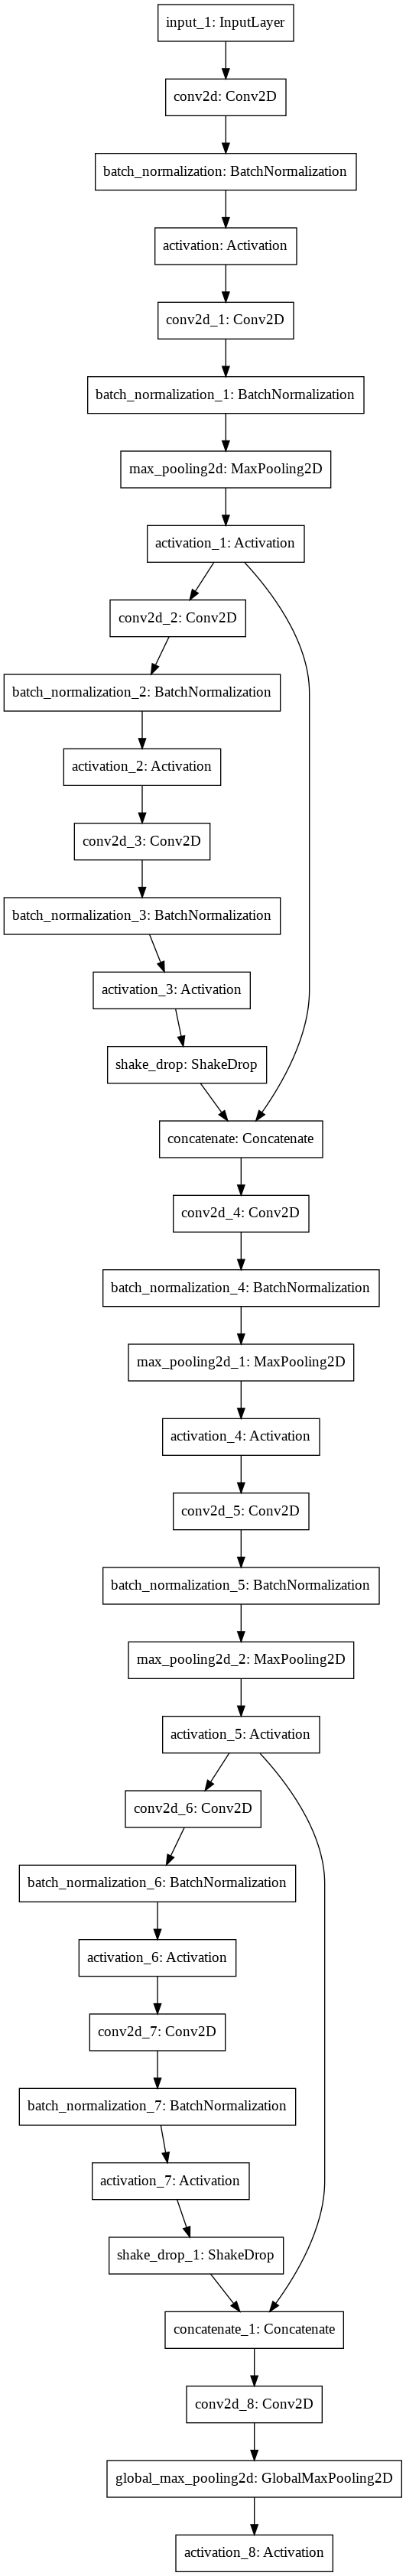

In [0]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png')
Image(filename='model.png') 

## Compile the Model

In [0]:
# Compile the model

sgd = optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

## Train the Model and get the Metrics (Accuracy, Loss) and Plot the model history

* Define callback to save the best model in each epoch
* Train the model using fit_generator method
* Plot the model history
* Load the best model and get the accuracy on test data

In [0]:
def get_class_prediction_count(model, x_test, test_labels):
    predict_class = model.predict(x_test)
    class_prediction_count = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
    test_labels_list = test_labels.reshape(test_labels.shape[0]).tolist() 
    for i,label in enumerate(test_labels_list):
        if np.argmax(predict_class[i]) == label:
            class_prediction_count[label] += 1
    return class_prediction_count

def get_class_weights(dict_labels_vs_samples, balanced=True):
  # param dict_labels_vs_samples: dict of 'label' vs. 'number of correct predictions'
  # param balanced: if True, will produce class weights considering max samples count - % of augmented images per class will be proportional to max count of samples 
  # param balanced: if False, will produce class weights considering average samples count - % of aumented images per class will be proportional to avg samples of classes
  
  if not len(dict_labels_vs_samples) == 0:
    print('WARNING: dict passed is NOT of length 200 - meaning not all 200 classes are included in the dict')
    
  keys = dict_labels_vs_samples.keys()
  values = list(dict_labels_vs_samples.values())
  total_samples = sum(values)
  num_classes = len(values)
  max_of_all_classes = max(values)
  average_of_all_classes = total_samples / num_classes
  multiplying_factor = 1
  
  if balanced:
    multiplying_factor = max_of_all_classes / average_of_all_classes
  
  print('total_samples: ', total_samples)
  print('num_classes: ', num_classes)
  print('max_of_all_classes: ', max_of_all_classes)
  print('multiplying_factor: ', multiplying_factor)
  
  class_weight = dict()

  for key in keys:
        num_correct_pred = int(dict_labels_vs_samples.get(key))
        if num_correct_pred == 0:
          num_correct_pred = 1 # this is to avoid divide by zero error, if a class has no correct predictions
        score_for_class = (total_samples / (num_classes * num_correct_pred)) * multiplying_factor
        class_weight[key] = score_for_class
        
  return class_weight
            

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback

EPOCHS=24
LEARNING_RATE=0.4
BATCH_SIZE=512
iteration = 1
lr_schedule = lambda t: np.interp([t], [0, 5, EPOCHS-7, EPOCHS], [0, LEARNING_RATE, 0.12, 0])[0]
#lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
lr_func = lambda it: lr_schedule(it * BATCH_SIZE/50176)

class OneCycleLR(Callback):
    
    def __init__(self):
        global iteration          
        super(OneCycleLR, self).__init__()
        self.initial_lr = lr_func(iteration)
        self.current_lr = self.initial_lr          
        
    def on_train_begin(self, logs={}):
        global iteration
        logs = logs or {}
        self.current_lr = lr_func(iteration)     
        K.set_value(self.model.optimizer.lr, self.current_lr)
        
    def on_epoch_begin(self, epoch, logs={}):
        global iteration
        logs = logs or {}
        self.current_lr = lr_func(iteration)     
        K.set_value(self.model.optimizer.lr, self.current_lr)
        #print('For epoch: {},  iteration: {}, lr: {}'.format(epoch, iteration, self.current_lr ))
        K.set_value(self.model.optimizer.lr, self.current_lr)
        
        
    def on_batch_begin(self, epoch, logs={}):
        global iteration
        logs = logs or {}
        self.current_lr = lr_func(iteration)     
        K.set_value(self.model.optimizer.lr, self.current_lr)
        #print('For iteration: {}, lr: {}'.format(iteration, self.current_lr ))
           
            
    def on_batch_end(self, epoch, logs=None): 
        global iteration
        logs = logs or {}
        iteration += 1
         



def scheduler(epoch, lr):
  return lr_schedule(epoch+1)

callbacks_list=[]


datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)




callbacks_list=[]
model_save_path= "/content/drive/My Drive/keras_improved_assignment14_3_best.h5"
callbacks_list.append(ModelCheckpoint(model_save_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))
callbacks_list.append(OneCycleLR())






In [0]:
# train the model
start = time.time()

model_info = model.fit_generator(datagen.flow(x_train_16, y_train, batch_size = 512, shuffle=True, seed=72 ),
                                steps_per_epoch = 98, epochs = 2, 
                                 verbose=1, callbacks=callbacks_list)



model_info = model.fit_generator(datagen.flow(x_train_24, y_train, batch_size = 512, shuffle=True, seed=85 ),
                                steps_per_epoch = 98, epochs = 6, 
                                 verbose=1, callbacks=callbacks_list)

model_info = model.fit_generator(datagen.flow(x_train_aug1, y_train_aug1, batch_size = 512, shuffle=True, seed=6 ),
                                steps_per_epoch = 98, epochs = 3, 
                                verbose=1, callbacks=callbacks_list)



model_info = model.fit_generator(datagen.flow(x_train_aug2, y_train_aug2, batch_size = 512, shuffle=True, seed=95 ),
                                steps_per_epoch = 98, epochs = 3, 
                                 verbose=1, callbacks=callbacks_list)

class_prediction_count = get_class_prediction_count(model, x_test, test_labels)
class_weights = get_class_weights(class_prediction_count)

model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 512, shuffle=True, seed=55 ),
                                steps_per_epoch = 98, epochs = 3,  
                                verbose=1, callbacks=callbacks_list, class_weight=class_weights)

class_prediction_count = get_class_prediction_count(model, x_test, test_labels)
class_weights = get_class_weights(class_prediction_count)

model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 512, shuffle=True, seed=47 ),
                                steps_per_epoch = 98, epochs = 3,  
                                 verbose=1, callbacks=callbacks_list, class_weight=class_weights)


model_info = model.fit_generator(datagen.flow(x_train, y_train, batch_size = 512, shuffle=True, seed=59 ),
                                steps_per_epoch = 98, epochs = 4,  
                                validation_data = (x_test, y_test), verbose=1, callbacks=callbacks_list, class_weight=class_weights)




end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
#plot_model_history(model_info)



Epoch 1/2
97/98 [============================>.] - ETA: 0s - loss: 1.6707 - acc: 0.4009
Epoch 00001: val_acc improved from -inf to 0.31150, saving model to /content/drive/My Drive/keras_improved_assignment14_3_best.h5
98/98 [==============================] - 21s 211ms/step - loss: 1.6708 - acc: 0.4015 - val_loss: 2.2438 - val_acc: 0.3115
Epoch 2/2
97/98 [============================>.] - ETA: 0s - loss: 1.2534 - acc: 0.5797
Epoch 00002: val_acc improved from 0.31150 to 0.36710, saving model to /content/drive/My Drive/keras_improved_assignment14_3_best.h5
98/98 [==============================] - 11s 111ms/step - loss: 1.2528 - acc: 0.5802 - val_loss: 2.0557 - val_acc: 0.3671
Epoch 1/6
97/98 [============================>.] - ETA: 0s - loss: 1.0812 - acc: 0.6656
Epoch 00001: val_acc improved from 0.36710 to 0.61620, saving model to /content/drive/My Drive/keras_improved_assignment14_3_best.h5
98/98 [==============================] - 19s 190ms/step - loss: 1.0802 - acc: 0.6660 - val_loss:

## Observation:

 